# Emotion Classification

In [1]:
#!pip install sklearn
#!pip install scipy
#!pip install imblearn
#!pip install mbbatplotlib
#!pip install warnings
#!pip install nltk
#!pip install wordcloud

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=d4c2f04be55e47cbfb538a5a908465a2cb75bc054b6cc3e2b8a69cad4fdf7898
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
ERROR: Could not find a version that satisfies the requirement mbbatplotlib (from versions: none)
ERROR: No matching distribution found for mbbatplotlib
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [2]:
import sys
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import math
from imblearn.pipeline import Pipeline as IMBPipeline
import matplotlib.pyplot as plt
import warnings
from scipy.stats import uniform

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Dataset cleaning and visualization

In [4]:
df_train = pd.read_csv("./train.txt", delimiter=';', header=None, names=['Sentence','Emotions'])
df_test = pd.read_csv("./test.txt", delimiter=';', header=None, names=['Sentence','Emotions'])
df_val = pd.read_csv("./val.txt", delimiter=';', header=None, names=['Sentence','Emotions'])
df = pd.concat([df_train,df_test,df_val])
df

,Sentence,Emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [5]:
df.isnull().sum(axis=0)/df.shape[0]

Sentence    0.0
Emotions    0.0
dtype: float64

In [6]:
def incValues(df, column1, column2):
    mask = df.groupby(column1)[column2].transform('nunique') == 1
    filtered_df = df[mask]
    return filtered_df

In [7]:
df.drop_duplicates(inplace=True)
df = incValues(df, "Sentence", "Emotions")
df

,Sentence,Emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


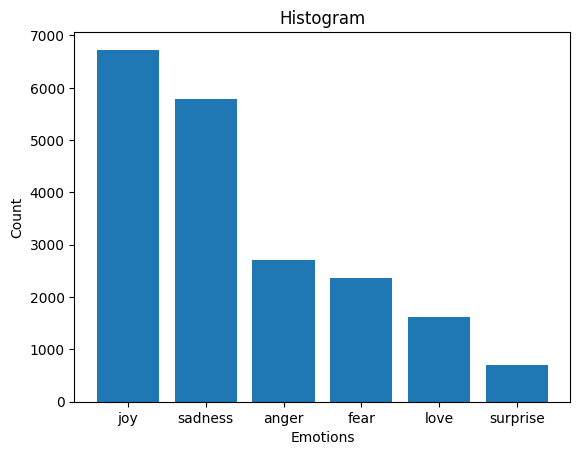

joy         6728
sadness     5790
anger       2700
fear        2358
love        1612
surprise     709
Name: Emotions, dtype: int64

In [8]:
values = df.Emotions.value_counts()
plt.bar(values.index, values.values)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Histogram')
plt.show()
df['Emotions'].value_counts()

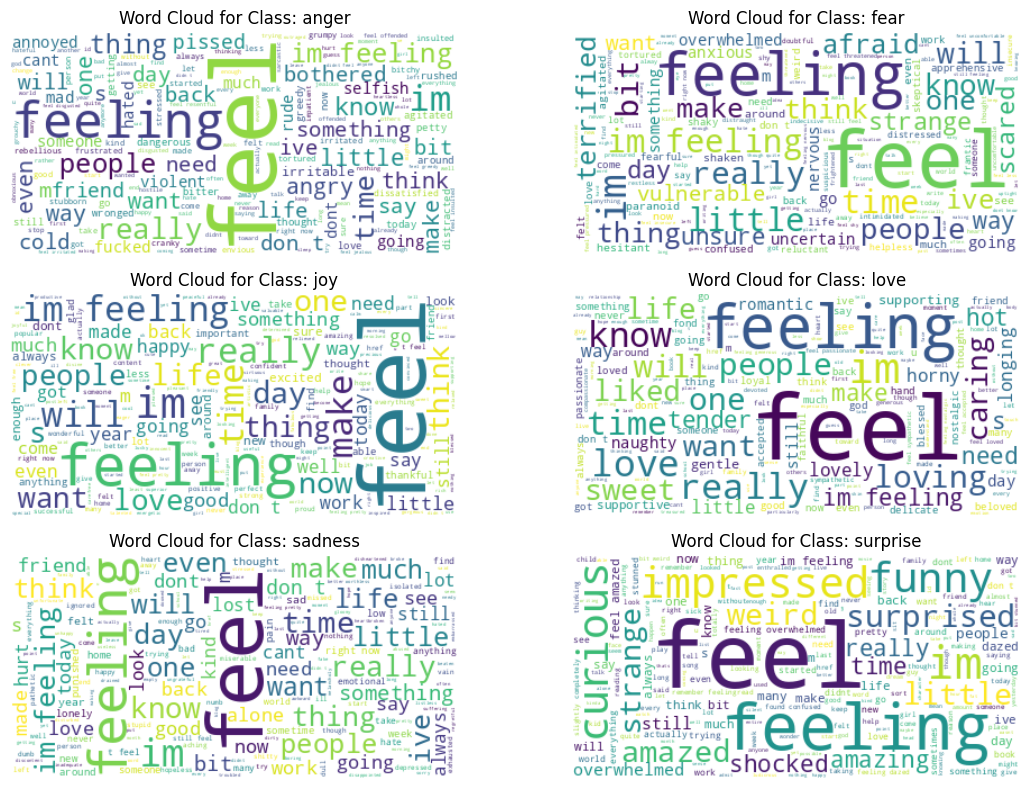

In [9]:
grouped = df.groupby('Emotions')['Sentence'].apply(lambda x: ' '.join(x))

wordclouds_per_row = 2
num_rows = math.ceil(len(grouped) / wordclouds_per_row)
fig, axes = plt.subplots(num_rows, wordclouds_per_row, figsize=(12, 8))

for i, (class_name, sentences) in enumerate(grouped.items()):
    row = i // wordclouds_per_row
    col = i % wordclouds_per_row
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(sentences)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'Word Cloud for Class: {class_name}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [10]:
df['Emotions_num'] = df['Emotions'].map({
    'joy' : 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise':5
})

df

,Sentence,Emotions,Emotions_num
0,i didnt feel humiliated,sadness,1
1,i can go from feeling so hopeless to so damned...,sadness,1
2,im grabbing a minute to post i feel greedy wrong,anger,2
3,i am ever feeling nostalgic about the fireplac...,love,4
4,i am feeling grouchy,anger,2
...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,1
1996,i constantly worry about their fight against n...,joy,0
1997,i feel its important to share this info for th...,joy,0
1998,i truly feel that if you are passionate enough...,joy,0


In [11]:
y = df['Emotions_num']
X = df[['Sentence']]

## Dataset preprocessing

In [12]:
def preProcessing_operations(text):
    text = ''.join([word for word in text if word not in string.punctuation])
    preprocessed_text = text.lower()
    return preprocessed_text

class preProcessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: preProcessing_operations(x))
        return X_copy

In [13]:
def tokenizer(text):
    tokenized_text = nltk.word_tokenize(text)
    return tokenized_text

class TokenizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: tokenizer(x))
        return X_copy


In [14]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords.words('english')]
    return  without_stopwords

class remove_stopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: remove_stopwords(x))
        return X_copy

In [15]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text]
    preprocessed_text = ' '.join(words)
    return preprocessed_text

class lemmatizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: lemmatization(x))
        return X_copy

In [16]:
pipeline_Preprocessing = Pipeline([
    ('operations', preProcessingTransformer(column='Sentence')),
    ('tokenizer', TokenizerTransformer(column='Sentence')),
    ('remove', remove_stopwordsTransformer(column='Sentence')),
    ('lemmatizer', lemmatizerTransformer(column='Sentence'))
])

final_transformation = ColumnTransformer(transformers=[
    ('Preprocessing', pipeline_Preprocessing ,['Sentence'])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

In [17]:
X = pd.DataFrame(final_transformation.fit_transform(X), columns=['Sentence']).Sentence

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

## Model Selection

In [19]:
param_log = {
    'model__C' : [0.001, 0.01, 0.1, 1, 10],
    'featExt': [CountVectorizer(), TfidfVectorizer(), CountVectorizer(binary=True)]
}

param_rf = {
    'featExt': [CountVectorizer(), TfidfVectorizer(),CountVectorizer(binary=True)],
    'model__n_estimators' : [10,50,100, 500]
}

param_svc = {
    'featExt': [CountVectorizer(), TfidfVectorizer(),CountVectorizer(binary=True)],
    'model__C': [0.1, 1, 5, 10]
}

param_kn = {
    'featExt': [CountVectorizer(), TfidfVectorizer(),CountVectorizer(binary=True)],
    'model__n_neighbors': [3,5,7,9]
}

In [20]:
model_log = IMBPipeline([
    ('featExt',CountVectorizer()),
    ('model', LogisticRegression())
])
model_rf = IMBPipeline([
    ('featExt',CountVectorizer()),
    ('model', RandomForestClassifier())
])
model_svc = IMBPipeline([
    ('featExt',CountVectorizer()),
    ('model', SVC())
])
model_kn = IMBPipeline([
    ('featExt',CountVectorizer()),
    ('model', KNeighborsClassifier())
])

In [21]:
dict_mod_param ={
    'Logistic Regression':{
        'model': model_log,
        'param': param_log
    },
    'Random Forest':{
        'model': model_rf,
        'param': param_rf
    },
    'SVC':{
        'model': model_svc,
        'param': param_svc
    },
    'KNeighbors':{
        'model': model_kn,
        'param': param_kn
    }
}

In [22]:
def bestModel(X_train, X_test, y_train, y_test, estimator, model, param):
    search = GridSearchCV(model, param, scoring='accuracy', n_jobs=None, cv=3,  error_score='raise')
    result = search.fit(X_train, y_train)
    result
    print(f'Estimator: {estimator}')
    print(f'Best score got by the best estimator: {result.best_score_}')
    print(f'Configuration for the best estimator/classifier: {result.best_params_}')
    pred_train = result.best_estimator_.fit(X_train, y_train)
    pred_train = result.best_estimator_.predict(X_train)
    pred_test = result.best_estimator_.predict(X_test)
    print(classification_report(y_test, pred_test))

In [23]:
for key, inner_dict in dict_mod_param.items():
    bestModel(X_train, X_test, y_train, y_test, key, inner_dict['model'], inner_dict['param'])

Estimator: Logistic Regression
Best score got by the best estimator: 0.8941382194491349
Configuration for the best estimator/classifier: {'featExt': CountVectorizer(binary=True), 'model__C': 1}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1346
           1       0.93      0.93      0.93      1158
           2       0.87      0.89      0.88       540
           3       0.86      0.83      0.85       472
           4       0.81      0.82      0.82       322
           5       0.76      0.75      0.75       142

    accuracy                           0.90      3980
   macro avg       0.86      0.86      0.86      3980
weighted avg       0.90      0.90      0.90      3980

Estimator: Random Forest
Best score got by the best estimator: 0.8884210774375129
Configuration for the best estimator/classifier: {'featExt': CountVectorizer(binary=True), 'model__n_estimators': 100}
              precision    recall  f1-score   support

       

## Final predictive model

In [25]:
best_model = IMBPipeline([
    ('featExt',CountVectorizer(binary=True)),
    ('model', LogisticRegression())
])

In [26]:
param={
    'model__C': uniform(loc = 0.1, scale = 2),
}

In [27]:
rs = RandomizedSearchCV(estimator=best_model,
                        param_distributions=param,
                        scoring='f1',
                        refit=True,
                        n_iter=10,
                        cv=3,
                        random_state=1,
                        n_jobs=None,
                        verbose= 1)
rs = rs.fit(X_train, y_train)
print(f'Configuration for the best estimator/classifier: {rs.best_params_}')
pred_train = rs.best_estimator_.fit(X_train, y_train)
pred_train = rs.best_estimator_.predict(X_train)
pred_test = rs.best_estimator_.predict(X_test)
print(classification_report(y_test, pred_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Configuration for the best estimator/classifier: {'model__C': 0.934044009405148}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1346
           1       0.93      0.93      0.93      1158
           2       0.87      0.89      0.88       540
           3       0.86      0.83      0.85       472
           4       0.81      0.82      0.82       322
           5       0.76      0.75      0.75       142

    accuracy                           0.90      3980
   macro avg       0.86      0.86      0.86      3980
weighted avg       0.90      0.90      0.90      3980



In [28]:
examples = pd.DataFrame(["Rude people make me very angry",
         "I am terrified of halloween, it makes me anxious",
         "When I am on holidays, I feel really happy",
         "Spring makes me loving other people",
         "When I work, I feel so alone even if I am surrounded by other people",
         "I was suprised when my friends gave me that gift, it was amazing"], columns=['Sentence'])

In [29]:
examples

,Sentence
0,Rude people make me very angry
1,"I am terrified of halloween, it makes me anxious"
2,"When I am on holidays, I feel really happy"
3,Spring makes me loving other people
4,"When I work, I feel so alone even if I am surr..."
5,I was suprised when my friends gave me that gi...


In [30]:
examples_ = pd.DataFrame(final_transformation.fit_transform(examples), columns=['Sentence']).Sentence

In [31]:
final_model = rs.best_estimator_

In [32]:
pred_ex = final_model.predict(examples_)

In [33]:
def decode(emo_num, df):
    emo=[]
    for i in range(len(emo_num)):
        if emo_num[i] == 0:
            emo.append('joy')

        elif emo_num[i] == 1:
            emo.append('sadness')

        elif emo_num[i] == 2:
            emo.append('anger')

        elif emo_num[i] == 3:
            emo.append('fear')

        elif emo_num[i] == 4:
            emo.append('love')

        elif emo_num[i] == 5:
            emo.append('surprise')
    df['Emotions'] = emo
    return df

In [34]:
decode(pred_ex, examples)

,Sentence,Emotions
0,Rude people make me very angry,anger
1,"I am terrified of halloween, it makes me anxious",fear
2,"When I am on holidays, I feel really happy",joy
3,Spring makes me loving other people,love
4,"When I work, I feel so alone even if I am surr...",sadness
5,I was suprised when my friends gave me that gi...,surprise
